# Temporal Segmentation Test Script

## Setup and Data Pre-Processing
- We need the data to be a series of images at set time steps so if we are passing in a video file or something like that, we need to convert it to a set of discrete images for SAM

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [54]:
def show_anns_reg(anns):
    if len(anns) == 0:
        return
    # sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((anns[0]['segmentation'].shape[0], anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [72]:
# make a list of colors
def random_colors(N):
    np.random.seed(1)
    color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    colors = np.array([color])
    for i in range(N-1):
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
        colors = np.concatenate([colors, [color]], axis=0)
    return colors

color_list = random_colors(100)

def show_mask(mask, ax, random_color=False, color=None):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    elif color is not None:
        color = color
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [3]:
image_dir = '/home/yashas/Documents/thesis/segment-anything/test-images/traj0/images0/'
image_prefix = 'im_'
image_suffix = '.jpg'

In [4]:
big_plot_dim = 8

In [5]:
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

large_sam_checkpoint = "/home/yashas/Documents/thesis/segment-anything/sam_vit_h_4b8939.pth"
large_model_type = "vit_h"

# small_sam_checkpoint = "/home/yashas/Documents/thesis/segment-anything/sam_vit_b_01ec64.pth"
# small_model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[large_model_type](checkpoint=large_sam_checkpoint)
sam.to(device=device)

/home/yashas/miniconda3/envs/pytorch_test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

## First image visualization and segmentation

In [6]:
image = cv2.imread(image_dir + image_prefix + '0' + image_suffix)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

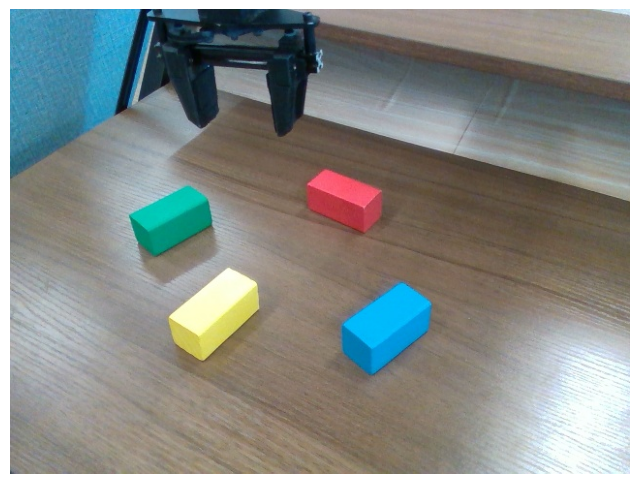

In [7]:
plt.figure(figsize=(big_plot_dim, big_plot_dim))
plt.imshow(image)
plt.axis('off')
plt.show()

In [8]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=16,
    pred_iou_thresh=0.95,
    stability_score_thresh=0.95,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,
    box_nms_thresh=0.1,
)

In [9]:
first_masks = mask_generator.generate(image)
len(first_masks)

12

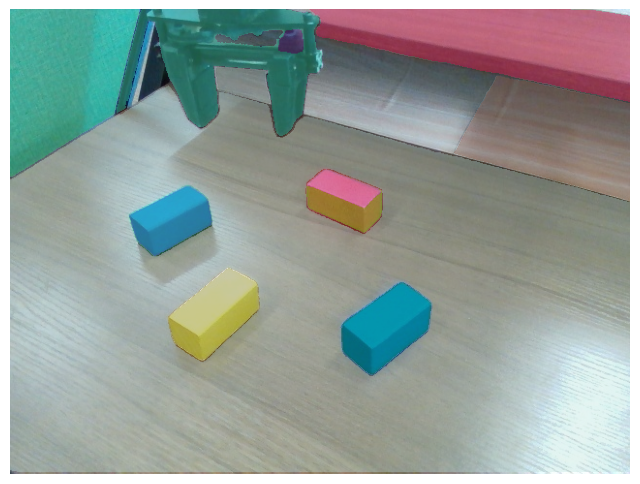

In [10]:
plt.figure(figsize=(big_plot_dim, big_plot_dim))
plt.imshow(image)
show_anns(first_masks)
plt.axis('off')
plt.show()

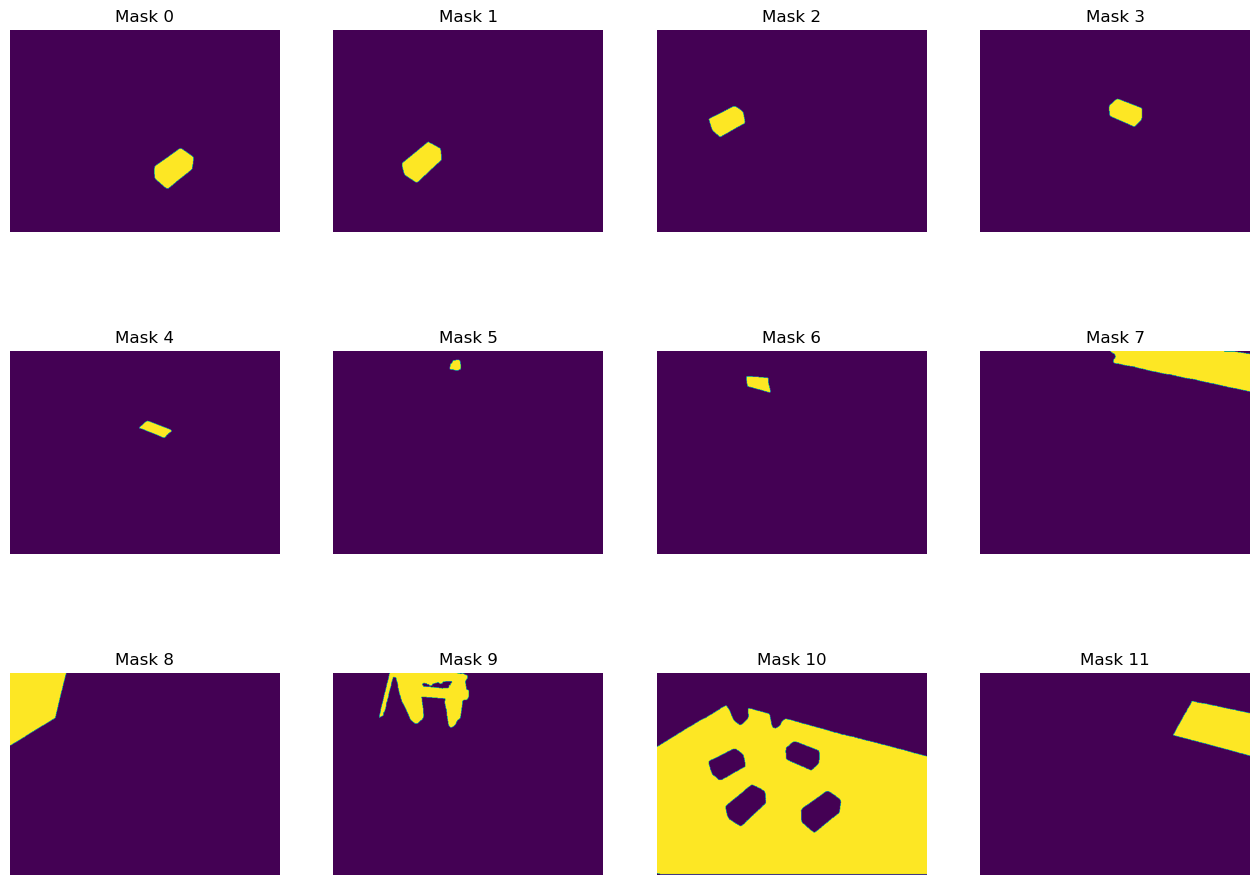

In [11]:
# Visualize each segmentation mask individually in a grid
n = len(first_masks)
cols = 4
rows = n // cols + 1
plt.figure(figsize=(16, 16))
for i, ann in enumerate(first_masks):
    plt.subplot(rows, cols, i + 1)
    plt.title(f"Mask {i}")
    plt.imshow(ann['segmentation'])
    plt.axis('off')

In [12]:
# Give in an array of mask numbers, combine all the masks and return the combined mask
def combine_masks(mask_nums, masks):
    combined_mask = np.zeros(masks[0]['segmentation'].shape, dtype=bool)
    for i in mask_nums:
        combined_mask = np.logical_or(combined_mask, masks[i]['segmentation'])
    return combined_mask

In [13]:
# Given an np.array of shape (mask_num, width, height), return the combined mask
def combine_masks_np(masks):
    combined_mask = np.zeros(masks[0].shape, dtype=bool)
    for mask in masks:
        combined_mask = np.logical_or(combined_mask, mask)
    return combined_mask

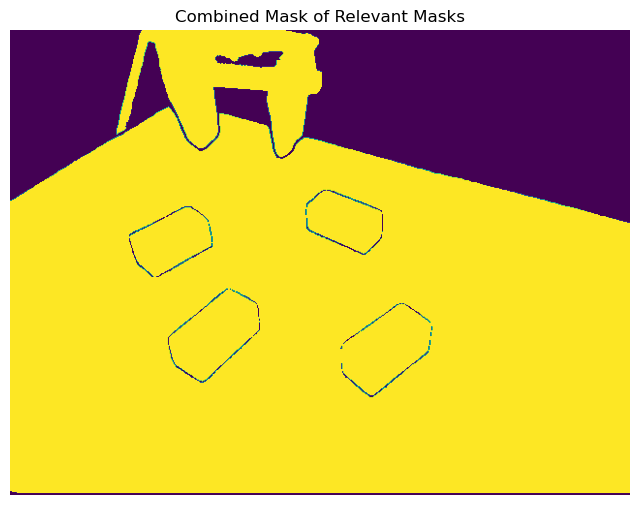

In [14]:
# Combine the masks and display the combined mask
relevant_masks = [0, 1, 2, 3, 9, 10]
relevant_first_mask_anns = [first_masks[i] for i in relevant_masks]
combined_mask = combine_masks(relevant_masks, first_masks)
plt.figure(figsize=(big_plot_dim, big_plot_dim))
plt.imshow(combined_mask)
plt.title("Combined Mask of Relevant Masks")
plt.axis('off')
plt.show()

In [74]:
total_masks_over_time = np.array([[relevant_first_mask_anns[i]['segmentation'] for i in range(len(relevant_first_mask_anns))]])
# the shape of this is [frame_num, mask_num, height, width]
print(total_masks_over_time.shape)

(1, 6, 480, 640)


## Segmentations over time of the rest of the images

In [16]:
# figure out how many images there are in the directory
import os

image_files = os.listdir(image_dir)
image_files = [f for f in image_files if f.endswith('.jpg')]
image_files = sorted(image_files)
n_images = len(image_files)
print(f"Found {n_images} images in the directory")

Found 47 images in the directory


In [17]:
# sam = sam_model_registry[small_model_type](checkpoint=small_sam_checkpoint)
# sam.to(device=device)

predictor = SamPredictor(sam)

In [32]:
# function to get the bounding box given a mask, not using openCV
def get_box(segmentation_mask):
    rows = len(segmentation_mask)
    if rows == 0:
        return None
    cols = len(segmentation_mask[0])
    
    # Initialize bounding box coordinates
    min_row, min_col = rows, cols
    max_row, max_col = 0, 0
    
    # Iterate through the segmentation mask to find True values
    for row in range(rows):
        for col in range(cols):
            if segmentation_mask[row][col]:
                min_row = min(min_row, row)
                min_col = min(min_col, col)
                max_row = max(max_row, row)
                max_col = max(max_col, col)
    
    # If no True values found, return None
    if min_row == rows or min_col == cols:
        return None
    
    return min_col, min_row, max_col, max_row

In [30]:
# test out the get_box function
box = get_box(relevant_first_mask_anns[0]['segmentation'])
print(box)
print(relevant_first_mask_anns[0]['bbox'])

(342, 282, 434, 376)
[342, 282, 92, 94]


In [75]:
# Using the bounding box of each mask in relevant_first_mask_anns, run segment-anything on the bounding box
box_margin = 0.2    # margin around the bounding box

frame_num = 1
image = cv2.imread(image_dir + image_prefix + str(frame_num) + image_suffix)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)
masks_in_frame = np.zeros((0, image.shape[0], image.shape[1]), dtype=bool)
for seg_num in range(len(relevant_first_mask_anns)):
    x, y, w, h = relevant_first_mask_anns[seg_num]['bbox']
    input_box = np.array([x, y, x + w, y + h])

    # Add a margin to the bounding box
    input_box[0] = max(0, input_box[0] - w * box_margin)
    input_box[1] = max(0, input_box[1] - h * box_margin)
    input_box[2] = min(image.shape[1], input_box[2] + w * box_margin)
    input_box[3] = min(image.shape[0], input_box[3] + h * box_margin)

    # Actually generate the mask
    masks, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box = input_box,
        multimask_output=False,
    )
    # Visualize the masks and bounding boxes in a grid pattern
    # plt.figure(figsize=(big_plot_dim, big_plot_dim))
    # plt.title(f"Frame {frame_num}, Mask {seg_num}")
    # plt.imshow(image)
    # show_mask(masks[0], plt.gca())
    # show_box(input_box, plt.gca())
    # plt.axis('off')
    # plt.show()

    # the shape of this is [mask_num, height, width]
    masks_in_frame = np.append(masks_in_frame, masks, axis=0)

total_masks_over_time = np.append(total_masks_over_time, [masks_in_frame], axis=0)
print(total_masks_over_time.shape)

(2, 6, 480, 640)


In [76]:
box_margin = 0.1    # margin around the bounding box

for frame_num in range(2, n_images):
    image = cv2.imread(image_dir + image_prefix + str(frame_num) + image_suffix)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image)
    masks_in_frame = np.zeros((0, image.shape[0], image.shape[1]), dtype=bool)
    for seg_num in range(len(relevant_first_mask_anns)):
        # x, y, w, h = relevant_first_mask_anns[seg_num]['bbox']
        # input_box = np.array([x, y, x + w, y + h])
        input_box = np.array(get_box(total_masks_over_time[frame_num - 1][seg_num]))
        # print(input_box)
        x, y, = input_box[0], input_box[1]
        w, h = input_box[2] - input_box[0], input_box[3] - input_box[1]

        # Add a margin to the bounding box
        input_box[0] = max(0, input_box[0] - w * box_margin)
        input_box[1] = max(0, input_box[1] - h * box_margin)
        input_box[2] = min(image.shape[1], input_box[2] + w * box_margin)
        input_box[3] = min(image.shape[0], input_box[3] + h * box_margin)

        # Actually generate the mask
        masks, _, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box = input_box,
            multimask_output=False,
        )

        # Visualize the masks and bounding boxes in a grid pattern
        # plt.figure(figsize=(big_plot_dim, big_plot_dim))
        # plt.title(f"Frame {frame_num}, Mask {seg_num}")
        # plt.imshow(image)
        # show_mask(masks[0], plt.gca())
        # show_box(input_box, plt.gca())
        # plt.axis('off')
        # plt.show()

        # the shape of this is [mask_num, height, width]
        masks_in_frame = np.append(masks_in_frame, masks, axis=0)

    total_masks_over_time = np.append(total_masks_over_time, [masks_in_frame], axis=0)
    print(total_masks_over_time.shape)

(3, 6, 480, 640)
(4, 6, 480, 640)
(5, 6, 480, 640)
(6, 6, 480, 640)
(7, 6, 480, 640)
(8, 6, 480, 640)
(9, 6, 480, 640)
(10, 6, 480, 640)
(11, 6, 480, 640)
(12, 6, 480, 640)
(13, 6, 480, 640)
(14, 6, 480, 640)
(15, 6, 480, 640)
(16, 6, 480, 640)
(17, 6, 480, 640)
(18, 6, 480, 640)
(19, 6, 480, 640)
(20, 6, 480, 640)
(21, 6, 480, 640)
(22, 6, 480, 640)
(23, 6, 480, 640)
(24, 6, 480, 640)
(25, 6, 480, 640)
(26, 6, 480, 640)
(27, 6, 480, 640)
(28, 6, 480, 640)
(29, 6, 480, 640)
(30, 6, 480, 640)
(31, 6, 480, 640)
(32, 6, 480, 640)
(33, 6, 480, 640)
(34, 6, 480, 640)
(35, 6, 480, 640)
(36, 6, 480, 640)
(37, 6, 480, 640)
(38, 6, 480, 640)
(39, 6, 480, 640)
(40, 6, 480, 640)
(41, 6, 480, 640)
(42, 6, 480, 640)
(43, 6, 480, 640)
(44, 6, 480, 640)
(45, 6, 480, 640)
(46, 6, 480, 640)
(47, 6, 480, 640)


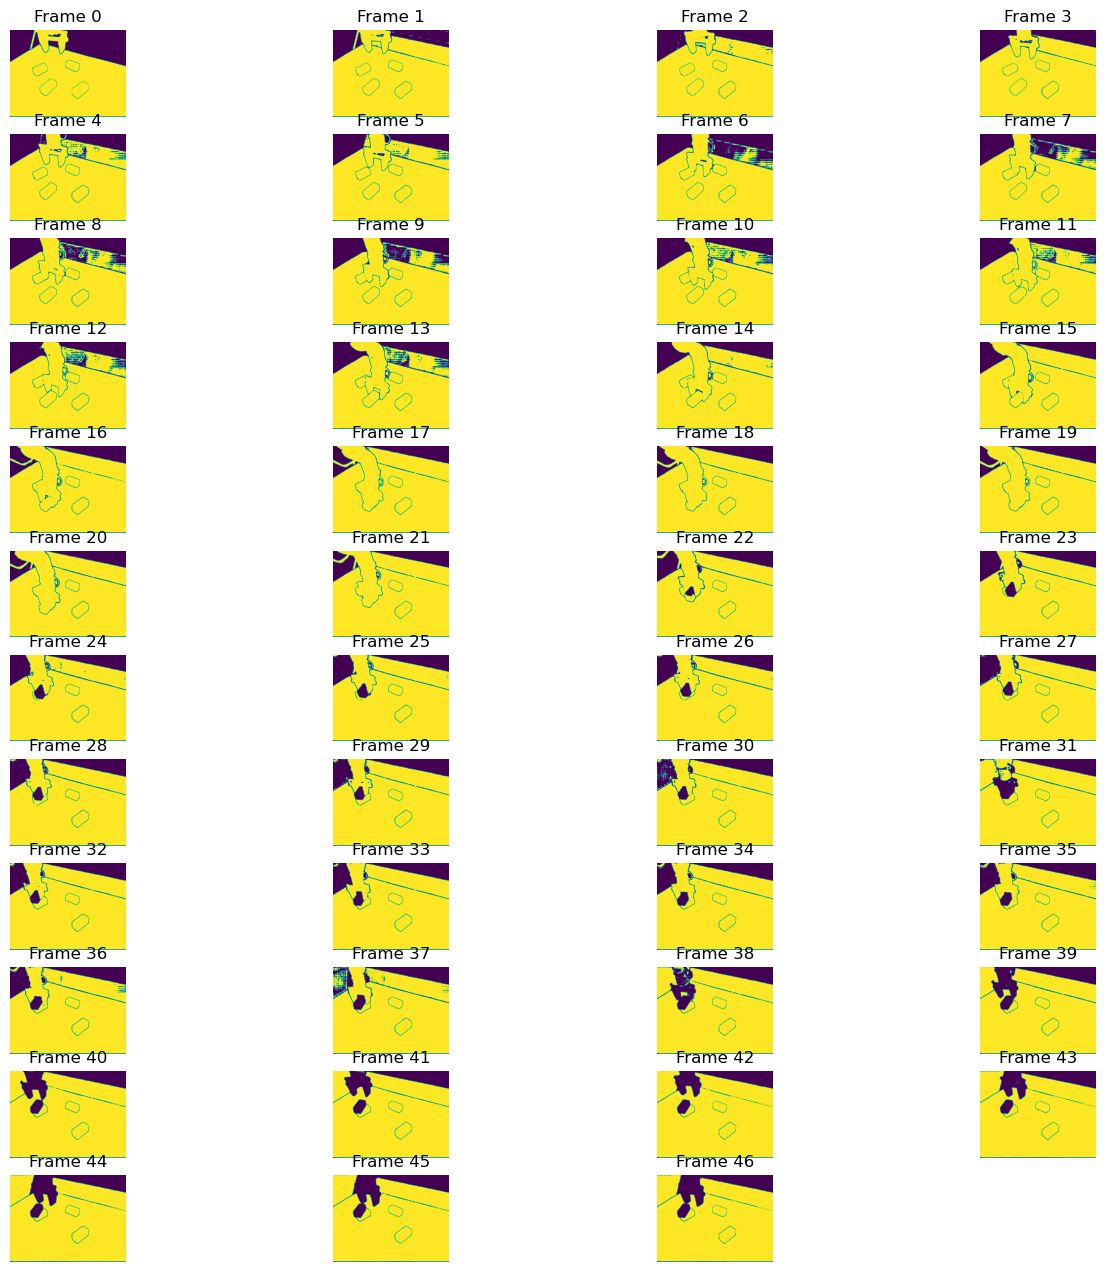

In [77]:
# Visualize the combined mask of each frame over time in a grid pattern
n = total_masks_over_time.shape[0]
cols = 4
plt.figure(figsize=(16, 16))
for i in range(n):
    plt.subplot(rows, cols, i + 1)
    plt.title(f"Frame {i}")
    plt.imshow(combine_masks_np(total_masks_over_time[i]))
    # plt.imshow(total_masks_over_time[i][5])   # to visualize a specific mask
    plt.axis('off')

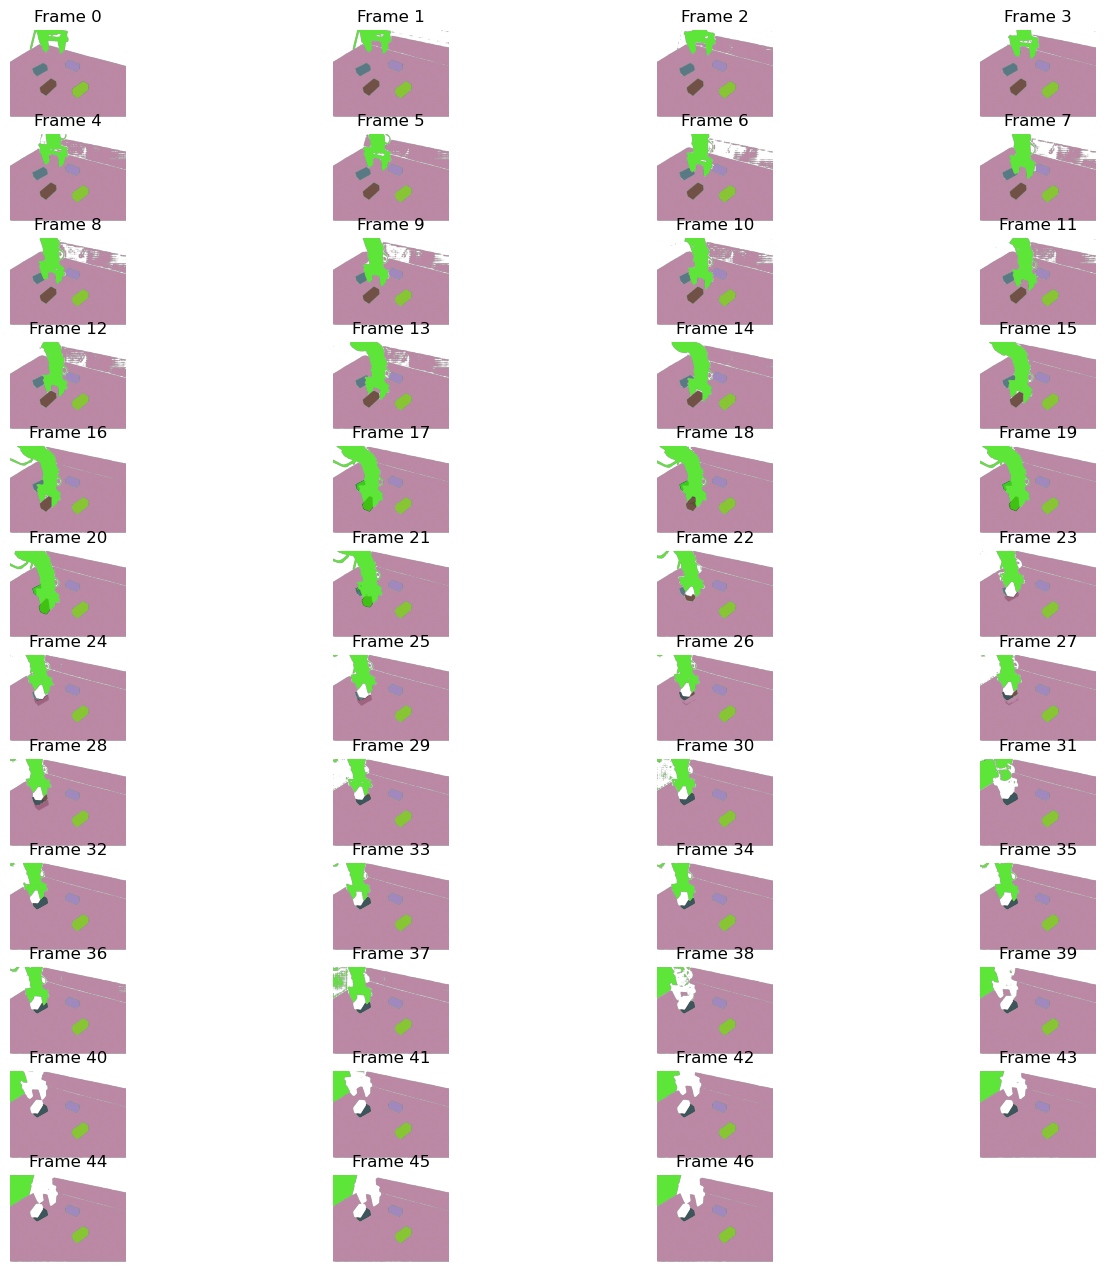

In [79]:
# Visualize the total_masks_over_time, with each mask in each frame being a different color
n = total_masks_over_time.shape[0]
cols = 4
rows = n // cols + 1
plt.figure(figsize=(16, 16))
for i in range(n):
    plt.subplot(rows, cols, i + 1)
    plt.title(f"Frame {i}")
    for j in range(len(relevant_first_mask_anns)):
        show_mask(total_masks_over_time[i][j], plt.gca(), color=np.array(color_list[j]))
    plt.axis('off')


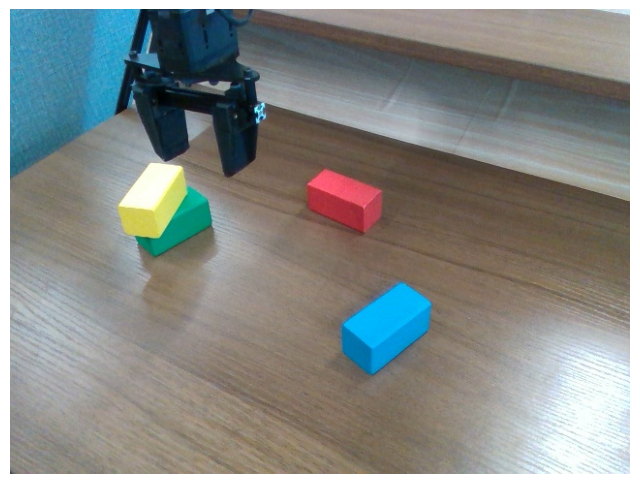

In [82]:
# Visualize all images in directory as animation
import time
from IPython.display import display, clear_output

for i in range(0, n_images):
    image = cv2.imread(image_dir + image_prefix + str(i) + image_suffix)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(big_plot_dim, big_plot_dim))
    plt.title(f"Frame {i}")
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

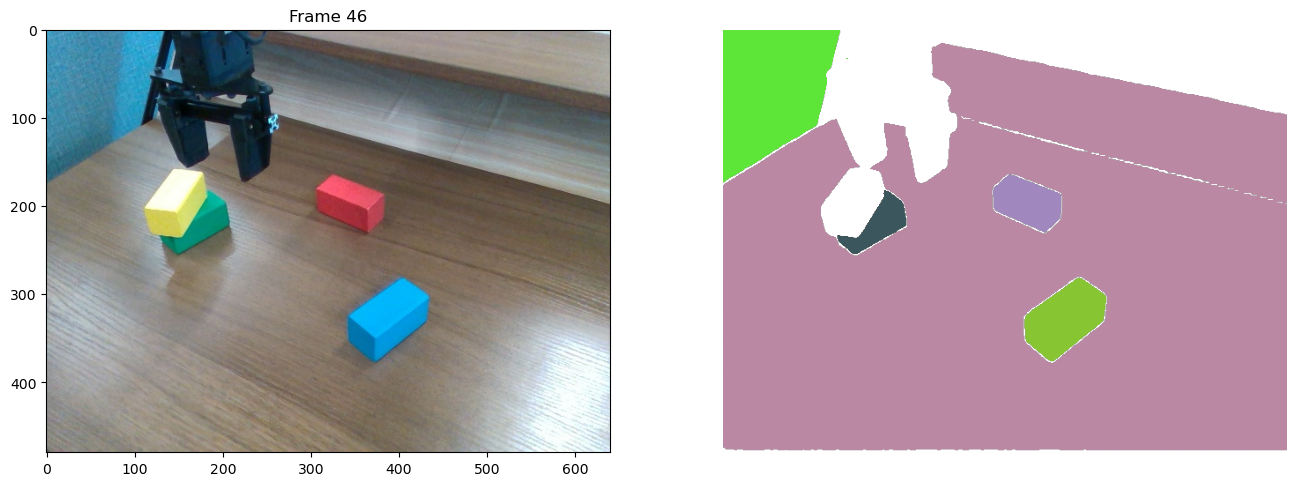

In [96]:
# Visualize the total_masks_over_time as an animation, with each mask in each frame being a different color, side by side with the real image, for comparison
for i in range(0, n_images):
    image = cv2.imread(image_dir + image_prefix + str(i) + image_suffix)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(big_plot_dim*2, big_plot_dim*2))
    plt.subplot(1, 2, 1)
    plt.title(f"Frame {i} Real Image")
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.title(f"Frame {i} Segmentation")
    for j in range(len(relevant_first_mask_anns)):
        show_mask(total_masks_over_time[i][j], plt.gca(), color=np.array(color_list[j]))
    plt.axis('off')
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

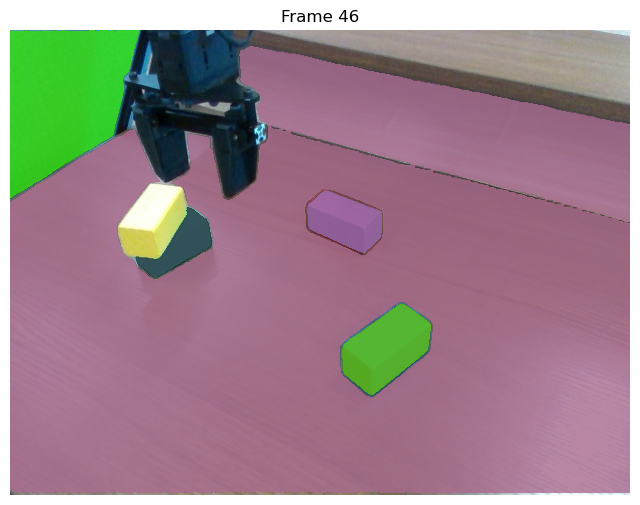

In [94]:
# Visualize the total_masks_over time as an animation and in the same plot as the real image, for comparison
for i in range(0, n_images):
    image = cv2.imread(image_dir + image_prefix + str(i) + image_suffix)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(big_plot_dim, big_plot_dim))
    plt.title(f"Frame {i}")
    plt.imshow(image)   # Comment this line to see only the masks
    for j in range(len(relevant_first_mask_anns)):
        show_mask(total_masks_over_time[i][j], plt.gca(), color=np.array(color_list[j]))
    plt.axis('off')
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

### Pickling necessary results for use with algorithmic tokenizer

In [92]:
import pickle

with open('total_masks_over_time.pkl', 'wb') as f:
    pickle.dump(total_masks_over_time, f)